### Package Imports

In [1]:
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from huggingface_hub import login
import pickle
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Set device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Download Datasets

In [ ]:
# Hugging Face
login("HUGGINGFACE_TOKEN")

# Load dataset
ds = load_dataset("ElenaSenger/Karrierewege_plus")
train_df_raw = pd.DataFrame(ds['train'])
validation_df_raw = pd.DataFrame(ds['validation'])
test_df_raw = pd.DataFrame(ds['test'])

# Save as CSVs
train_df_raw.to_csv('train_df.csv', index=False)
validation_df_raw.to_csv('val_df.csv', index=False)
test_df_raw.to_csv('test_df.csv', index=False)

In [4]:
train_df_raw = pd.read_csv('train_df.csv')
validation_df_raw = pd.read_csv('val_df.csv')
test_df_raw = pd.read_csv('test_df.csv')

In [5]:
# Drop unnecessary columns
train_df = train_df_raw.drop(columns=['new_job_title_en_occ', 'new_job_description_en_occ', 'preferredLabel_en','description_en'])
validation_df = validation_df_raw.drop(columns=['new_job_title_en_occ', 'new_job_description_en_occ', 'preferredLabel_en','description_en'])
test_df = test_df_raw.drop(columns=['new_job_title_en_occ', 'new_job_description_en_occ', 'preferredLabel_en','description_en'])
train_df.head()

,_id,experience_order,new_job_title_en_cp,new_job_description_en_cp
0,1,0,Housekeeper,Housekeeper: Responsible for maintaining the c...
1,1,1,Housekeeper,Housekeeper: Assists in the upkeep and mainten...
2,1,2,Housekeeper,Housekeeper: Ensures the overall tidiness and ...
3,1,3,Housekeeper,Housekeeper: Provides domestic assistance to h...
4,1,6,Grounds Worker,Grounds Worker: Maintains the upkeep of outdoo...


In [6]:
print('unique ids')
print(train_df['_id'].nunique())
print(validation_df['_id'].nunique())
print(test_df['_id'].nunique())
print('unique job titles')
print(train_df['new_job_title_en_cp'].nunique())
print(validation_df['new_job_title_en_cp'].nunique())
print(test_df['new_job_title_en_cp'].nunique())

print('length of each df')
print(len(train_df))
print(len(validation_df))
print(len(test_df))

print('total length')
sum = 52275 + 12601 + 12414
print(sum)
print('percentage of each df')
print(52275/sum)
print(12601/sum)
print(12414/sum)

unique ids
80000
10000
10000
unique job titles
52275
12601
12414
length of each df
401739
50414
50497
total length
77290
percentage of each df
0.676348816146979
0.16303532151636693
0.16061586233665415


Top 20 most common job titles:
new_job_title_en_cp
Housekeeper                        6155
Customer Service Representative    5833
Kitchen Assistant                  5541
Logistics Coordinator              4271
Relocation Specialist              3996
Construction Laborer               3838
Retail Sales Associate             3584
Inventory Coordinator              2606
Kitchen Support Staff              2394
Administrative Assistant           2243
Household Assistant                1889
Furniture Mover                    1840
Warehouse Worker                   1807
Kitchen Staff Member               1753
Logistics Specialist               1735
House Relocation Specialist        1669
Groundskeeper                      1577
Physical Laborer                   1566
Household Staff Member             1533
Metal Fabrication Specialist       1495
Name: count, dtype: int64

Job title distribution statistics:
Total unique job titles: 52275
Most common job title: Housekeeper (6155 occurrences)
Le

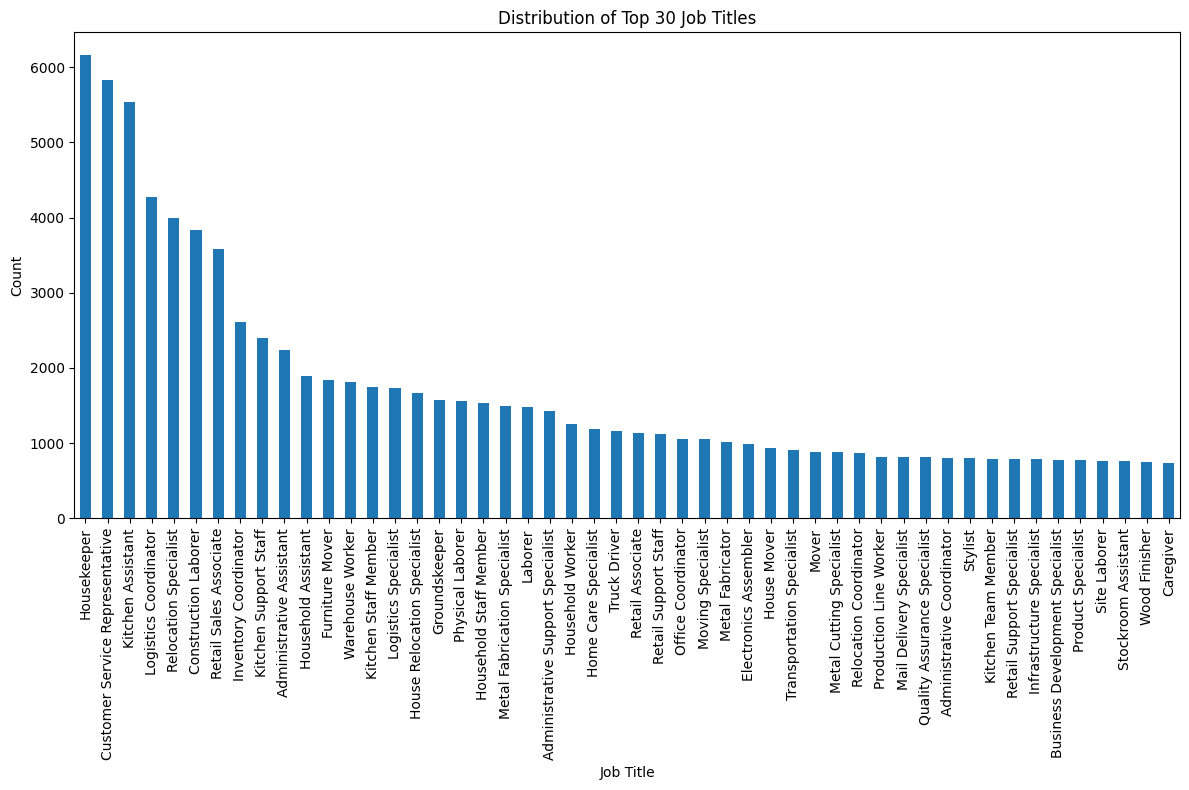

In [7]:
import matplotlib.pyplot as plt

# Frequency of each job title
job_title_counts = train_df_raw['new_job_title_en_cp'].value_counts()

# Top 20 most common job titles
print("Top 20 most common job titles:")
print(job_title_counts.head(20))

# Get basic statistics about job title distribution
print("\nJob title distribution statistics:")
print(f"Total unique job titles: {len(job_title_counts)}")
print(f"Most common job title: {job_title_counts.index[0]} ({job_title_counts.iloc[0]} occurrences)")
print(f"Least common job title: {job_title_counts.index[-1]} ({job_title_counts.iloc[-1]} occurrences)")
print(f"Mean occurrences per job title: {job_title_counts.mean():.2f}")
print(f"Median occurrences per job title: {job_title_counts.median():.2f}")

# Distribution of the top 30 job titles
plt.figure(figsize=(12, 8))
job_title_counts.head(50).plot(kind='bar')
plt.title('Distribution of Top 30 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [8]:
train_df['new_job_description_en_cp'] = train_df['new_job_description_en_cp'].str.split(':', n=1).str[1].str.strip()

validation_df['new_job_description_en_cp'] = validation_df['new_job_description_en_cp'].str.split(':', n=1).str[1].str.strip()

test_df['new_job_description_en_cp'] = test_df['new_job_description_en_cp'].str.split(':', n=1).str[1].str.strip()

In [9]:
job_titles = set(train_df_raw['new_job_title_en_cp']).union(validation_df_raw['new_job_title_en_cp'],test_df_raw['new_job_title_en_cp'])

job_vocab = {}
for i, job_title in enumerate(sorted(job_titles), start=1):
    job_vocab[job_title] = i
job_vocab

idx_to_job = {}
for title, idx in job_vocab.items():
    idx_to_job[idx] = title

# Special tokens
job_vocab['<PAD>'] = 0 
idx_to_job[0] = '<PAD>'
unknown_idx = len(job_vocab)
job_vocab['<UNK>'] = unknown_idx
idx_to_job[unknown_idx] = '<UNK>'

In [10]:
def match_titles_to_descriptions(df, field_name="new_job_description_en_cp"):

    # Job job titles to descriptions
    job_desc_dict = {}
    for _, row in df.iterrows():
        title = row['new_job_title_en_cp']
        job_desc = row[field_name]

        if title not in job_desc_dict and pd.notna(job_desc): 
            job_desc_dict[title] = job_desc

    # Sorted list of job titles based on indices
    job_titles_sorted = [title for title, idx in sorted(job_vocab.items(), key=lambda x: x[1]) if title not in ['<PAD>', '<UNK>']]

    # Descriptions corresponding to the sorted job titles
    descriptions = []
    for title in job_titles_sorted:
        descriptions.append(job_desc_dict.get(title, ""))

    return descriptions

In [ ]:
def tfidf_feats(df, field_name="new_job_description_en_cp", max_features=100):
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Match
    descriptions = match_titles_to_descriptions(df, field_name)
    
    # Fit and transform
    vectorizer = TfidfVectorizer(max_features=max_features)
    desc_features = vectorizer.fit_transform(descriptions).toarray()
    
    # Add one additional row for padding
    padding_features = np.zeros((1, desc_features.shape[1]))
    unknown_features = np.mean(desc_features, axis=0, keepdims=True)
    final_features = np.vstack([padding_features, desc_features, unknown_features])
    
    return final_features

# Feature stack
full_df = pd.concat([train_df_raw, validation_df_raw, test_df_raw])

# tfidf features
job_features = tfidf_feats(full_df, max_features=100)
job_features_tensor = torch.FloatTensor(job_features).to(device)

In [12]:
def create_career_sequences(df):
    sequences = []
    for person_id in df['_id'].unique():
        person_df = df[df['_id'] == person_id]
        sorted_jobs = person_df.sort_values('experience_order')
        job_titles = sorted_jobs['new_job_title_en_cp'].tolist()
        if len(job_titles) >= 2:
            job_indices = [job_vocab.get(title, unknown_idx) for title in job_titles]
            sequences.append(job_indices)
    return sequences

train_sequences = create_career_sequences(train_df_raw)
valid_sequences = create_career_sequences(validation_df_raw)
test_sequences = create_career_sequences(test_df_raw)

In [13]:
class SimpleCareerDataset(torch.utils.data.Dataset):
    """Dataset for career sequence data."""
    
    def __init__(self, career_sequences):
        self.sequences = career_sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        # Input = all jobs except the last one
        input_seq = sequence[:-1]
        
        # Target = the last job
        target = sequence[-1]
        
        return input_seq, len(input_seq), target

In [14]:
def collate_pad_sequences(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to the maximum length in the batch.
    """
    input_seqs, lengths, targets = zip(*batch)
    
    # Convert input sequences to tensors and pad
    input_seqs = [torch.LongTensor(seq) for seq in input_seqs]
    padded_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    
    # Convert lengths and targets to tensors
    lengths = torch.LongTensor(lengths)
    targets = torch.LongTensor(targets)
    
    return padded_seqs, lengths, targets

In [15]:
train_dataset = SimpleCareerDataset(train_sequences)
valid_dataset = SimpleCareerDataset(valid_sequences)
test_dataset = SimpleCareerDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_pad_sequences)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=collate_pad_sequences)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_pad_sequences)

### Define Model

In [16]:
class CareerLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        emb_dim: int,
        feat_dim: int,
        hid_dim: int,
        out_dim: int,
        num_layers: int = 2,
        dropout: float = 0.3,
        bidirectional: bool = True
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        lstm_input_dim = emb_dim + feat_dim
        self.lstm = nn.LSTM(
            lstm_input_dim,
            hid_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hid_dim * 2 if bidirectional else hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, seqs, lengths, job_feats):
        emb = self.embedding(seqs)
        feats = job_feats[seqs]
        x = torch.cat([emb, feats], dim=2)
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (hidden, _) = self.lstm(packed)
        
        # Bidirectional LSTM
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        hidden = self.dropout(hidden)
        return self.fc(hidden)

### Train Model

In [17]:
vocab_size    = len(job_vocab)
feature_dim   = job_features_tensor.size(1)
embedding_dim = 128
hidden_dim    = 256
output_dim    = vocab_size
learning_rate = 1e-3
n_epochs      = 10

model = CareerLSTM(vocab_size, embedding_dim, feature_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Loop to Train
best_val_acc = 0.0

for epoch in range(1, n_epochs + 1):
    # Train
    model.train()
    train_loss = train_correct = train_total = 0
    for seqs, lengths, labels in train_loader:
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seqs, lengths, job_features_tensor)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validate
    model.eval()
    val_loss = val_correct = val_total = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for seqs, lengths, labels in valid_loader:
            seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
            logits = model(seqs, lengths, job_features_tensor)
            loss = criterion(logits, labels)

            val_loss += loss.item() * labels.size(0)
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(logits.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted', zero_division=0)

    print(
        f"Epoch {epoch:2d} | "
        f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
        f"Val loss={val_loss:.4f}, acc={val_acc:.4f}, "
        f"precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "career_lstm_best.pt")
        print(f"Best model (val_acc={best_val_acc:.4f}) SAVED")

Epoch  1 | Train loss=8.9834, acc=0.0494 | Val loss=8.6555, acc=0.0641, precision=0.0295, recall=0.0641, f1=0.0295
Best model (val_acc=0.0641) SAVED
Epoch  2 | Train loss=8.0043, acc=0.0834 | Val loss=8.6200, acc=0.0883, precision=0.0475, recall=0.0883, f1=0.0492
Best model (val_acc=0.0883) SAVED
Epoch  3 | Train loss=7.1499, acc=0.1124 | Val loss=8.8252, acc=0.1033, precision=0.0604, recall=0.1033, f1=0.0665
Best model (val_acc=0.1033) SAVED
Epoch  4 | Train loss=6.0514, acc=0.1479 | Val loss=9.2562, acc=0.1045, precision=0.0690, recall=0.1045, f1=0.0749
Best model (val_acc=0.1045) SAVED
Epoch  5 | Train loss=4.8698, acc=0.2307 | Val loss=9.7858, acc=0.1045, precision=0.0740, recall=0.1045, f1=0.0788
Epoch  6 | Train loss=3.8645, acc=0.3449 | Val loss=10.3026, acc=0.1026, precision=0.0759, recall=0.1026, f1=0.0794
Epoch  7 | Train loss=3.1753, acc=0.4324 | Val loss=10.7350, acc=0.0978, precision=0.0736, recall=0.0978, f1=0.0779
Epoch  8 | Train loss=2.7212, acc=0.4960 | Val loss=11.00

In [19]:
def predict_next_career(
    model: nn.Module,
    title_sequence: list[str],
    job_vocab: dict[str, int],
    idx_to_job: dict[int, str],
    job_feats: torch.Tensor,
    device: torch.device,
    top_k: int = 3
):
    model.eval()
    idxs = [job_vocab.get(t, 0) for t in title_sequence]
    seq = torch.LongTensor([idxs]).to(device)
    length = torch.LongTensor([len(idxs)]).to(device)

    with torch.no_grad():
        logits = model(seq, length, job_feats)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        top_probs, top_indices = probs.topk(top_k)
        predictions = [
            (idx_to_job.get(int(idx), "<UNK>"), float(prob))
            for idx, prob in zip(top_indices, top_probs)
        ]
        return predictions

In [20]:
model.load_state_dict(torch.load("career_lstm_best.pt"))
predictions = predict_next_career(
    model,
    ["Office Support Specialist", "Financial Operations Coordinator", "Administrative Professional"],
    job_vocab,
    idx_to_job,
    job_features_tensor,
    device,
    top_k=5
)
for title, prob in predictions:
    print(f"Predicted: {title}, Confidence: {prob:.4f}")

Predicted: Executive Assistant, Confidence: 0.1127
Predicted: Customer Service Representative, Confidence: 0.0537
Predicted: Executive Support Specialist, Confidence: 0.0418
Predicted: Language Facilitator, Confidence: 0.0284
Predicted: Office Operations Manager, Confidence: 0.0203


/var/folders/5t/g2j6fnb12xd9jh0t1l87b03m0000gn/T/ipykernel_61119/863587818.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("career_lstm_